# Project 5
Graph Coloring Heuristics using local search.

This notebook contains the graph coloring portion of the project, implementing simple steepest descent, as well as a genetic algorithm solution.

For this project, the graph coloring was done in the [Julia](https://julialang.org/) programming language. This allows for using Jupyter notebooks for development and easy visualization of graphs. To view results, the `*.ipynb` file can be opened in Jupyter, the `*.jl` file can be run in Julia, or a PDF has been exported with all code and outputs. Output files are created as in all other projects, and additionally, plots of the best solutions are included.                 

The two graph coloring algorithms implemented are steepest descent and genetic algorithms. Steepest descent produces worse solutions faster, while genetic algorithms generally produce better solutions but can take a lot of time. In general, the solutions found and runtimes for GAs could be greatly improved by tuning the hyperparameters. With four degrees of freedom (initial population, generations, selection percent and chance of mutation), a proper search for the best parameters could not be performed in the time allotted. The steepest descent algorithm is designed to simply find the local optima and stop there. If this algorithm is modified to find the best neighbor even if it is worse and go there, it will often find better solutions, but takes more time. 

In [1]:
using LightGraphs
using MetaGraphs
using GraphPlot
using Glob

## Load Graphs
This function loads graphs from the `.input` text files as a LightGraphs object.

In [4]:
function loadGraph(fn)
    open(fn) do f
        s = read(f, String)
        s = split(s, '\n')
        nCols = parse(Int, s[1])
        nv = parse(Int, split(s[2], ' ')[1])
        g = SimpleGraph(nv)
        for i=3:length(s)-1
            start = parse(Int, split(s[i], ' ')[1])+1
            fin =   parse(Int, split(s[i], ' ')[2])+1
            add_edge!(g, start, fin)
        end
        mg = MetaGraph(g)
        set_prop!(mg, :nColors, nCols)
        set_prop!(mg, :name, split(fn, '/')[end])
        return mg
    end
end

loadGraph (generic function with 1 method)

## Write Solution to File
Writes number of colors, number of conflicts, and colors of each node to a file

In [50]:
function writeSolution(g, folder)
    n = get_prop(g, :name)
    n = n[1:end-6]*".output"
    nc = get_prop(g, :nColors)
    open(folder*n, "w+") do f
        confs = getConflicts(g)
        write(f, "Number of Colors: $(nc)\n")
        write(f, "Best solution: $(confs) conflicts\n")
        for v in vertices(g)
            write(f, "Node $(v): $(get_prop(g, v, :color))\n")
        end
    end
end

writeSolution (generic function with 1 method)

## Write Image of Solution to File


In [114]:
using Colors, Compose
import Cairo, Fontconfig

In [111]:
function writeImage(g, folder)
    n = get_prop(g, :name)
    n = n[1:end-6]*".png"
    nc = get_prop(g, :nColors)
    c1 = colorant"steelblue1"
    c2 = colorant"crimson"
    fillc = range(c1, stop=c2, length=nc)
    elabs = [get_prop(g, e.src, :color) == get_prop(g, e.dst, :color) ? "x" : "" for e in edges(g)]
    cs = [get_prop(g, v, :color) for v in vertices(g)]
    c = [fillc[i+1] for i in cs]
    draw(PNG(folder*n, 16cm, 16cm), gplot(g, nodefillc=c, nodelabel=1:nv(g), edgelabel=elabs))
end

writeImage (generic function with 1 method)

## Plotting Utility
Allows for plotting graphs with `x` over edges with conflict and color numbers on each node

In [137]:
function plotColors(g)
    n = get_prop(g, :name)
    n = n[1:end-6]*".png"
    nc = get_prop(g, :nColors)
    c1 = colorant"steelblue1"
    c2 = colorant"crimson"
    fillc = range(c1, stop=c2, length=nc)
    elabs = [get_prop(g, e.src, :color) == get_prop(g, e.dst, :color) ? "x" : "" for e in edges(g)]
    cs = [get_prop(g, v, :color) for v in vertices(g)]
    c = [fillc[i+1] for i in cs]
    gplot(g, nodefillc=c, nodelabel=1:nv(g), edgelabel=elabs)
end

plotColors (generic function with 1 method)

In [131]:
eg = loadGraph("instances/color12-4.input")
init!(eg)

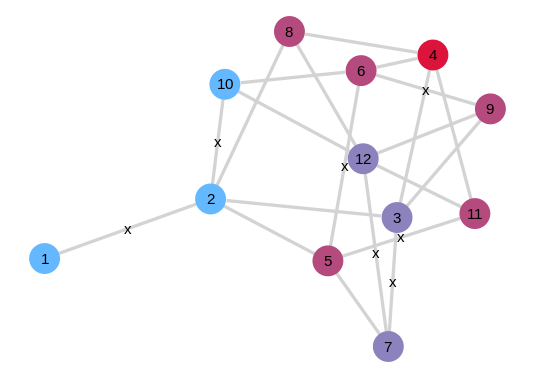

In [138]:
plotColors(eg)

## Initialization
Randomly initialize colors of graph (in place version has `!`)

In [35]:
function init!(g)
    for v in vertices(g)
        nc = get_prop(g, :nColors)
        color = rand(0:nc-1)
        set_prop!(g, v, :color, color)
    end
end

init! (generic function with 1 method)

In [7]:
function init(g)
    cg = copy(g)
    init!(cg)
    return cg
end

init (generic function with 1 method)

## Counting Conflicts
This function allows for easy counting of conflicts in a graph instance

In [9]:
function getConflicts(g)
    return sum([get_prop(g, e.src, :color) == get_prop(g, e.dst, :color) for e in edges(g)])
end

getConflicts (generic function with 1 method)

## Neighborhood
To keep a small neighborhood, neighborhood for graph coloring is all graphs that could be created by augmenting the color of one node. This leaves $n$ possible neighbors

In [41]:
function getBestNeighbor(g)
    best = g
    for v in vertices(g)
        new = copy(g)
        newc = (get_prop(new, v, :color) + 1) % get_prop(g, :nColors)
        set_prop!(new, v, :color, newc)
        if getConflicts(new) <= getConflicts(best)
            best = new
        end
    end
    if best == g
        return false
    else
        return best
    end
end
        

getBestNeighbor (generic function with 1 method)

## Descent Strategy
Simply get the best neighbor every iteration (false returned if no better neighbors)

In [53]:
function steepestDescent(g)
    cg = copy(g)
    while true
        new = getBestNeighbor(cg)
        if new != false
            cg = new
        else
            return cg
        end
    end
end

steepestDescent (generic function with 2 methods)

## Run on All Input Files

In [36]:
using Glob

In [38]:
fs = glob("color*.input", "instances")
getNum(str) = parse(Int, str[16:end-8])
sort!(fs, lt=(a,b)->getNum(a) < getNum(b))

11-element Array{String,1}:
 "instances/color12-3.input" 
 "instances/color12-4.input" 
 "instances/color24-4.input" 
 "instances/color24-5.input" 
 "instances/color48-5.input" 
 "instances/color48-6.input" 
 "instances/color96-6.input" 
 "instances/color96-7.input" 
 "instances/color192-6.input"
 "instances/color192-7.input"
 "instances/color192-8.input"

In [116]:
for f in fs
    fn = split(f, '/')[end]
    g = loadGraph(f)
    init!(g)
    g = steepestDescent(g)
    confs = getConflicts(g)
    writeSolution(g, "sdoutputs/")
    writeImage(g, "sdoutputs/imgs/")
    println("Instance $fn: $(confs) conflicts")
end 

Instance color12-3.input: 8 conflicts
Instance color12-4.input: 5 conflicts
Instance color24-4.input: 22 conflicts
Instance color24-5.input: 13 conflicts
Instance color48-5.input: 52 conflicts
Instance color48-6.input: 34 conflicts
Instance color96-6.input: 130 conflicts
Instance color96-7.input: 135 conflicts
Instance color192-6.input: 382 conflicts
Instance color192-7.input: 348 conflicts
Instance color192-8.input: 285 conflicts


# Genetic Algorithm

## Initialize Population

In [55]:
function initPop(g, size)
    pop = [init(g) for i=1:size]
    return pop
end

initPop (generic function with 1 method)

## Fitness Function
Defined simply as the number conflicts subtracted from the number of edges. This way the minimum fitness is 0, and the maximum fitness is the number of edges.

In [56]:
function fitness(g)
    return ne(g) - getConflicts(g)
end

fitness (generic function with 1 method)

## Random Mutation

In [57]:
function mutate(g)
    v = rand(1:nv(g))
    nc = get_prop(g, :nColors)
    c = rand(0:nc-1)
    #println("Changing node $v to color $c")
end

mutate (generic function with 1 method)

## Mating
Each child solution product of 2 parent solutions. Parent solutions are chosen out of pool of selected solutions. Parents are chosen at random in proportion to their fitness. Uniformly distributed crossover point is chosen. Child inherits all colors from one parent up to crossover node, and from other parent after that point.  

*TODO*: try normal distribution for crossover point to avoid children almost exclusively from one parent. Also could try making crossover random but proportional to parent fitness.

In [58]:
function mate(g1, g2)
    cross = rand(1:nv(g1))
    child = copy(g1)
    for v=1:nv(g1)
        g1c = get_prop(g1, v, :color)
        g2c = get_prop(g2, v, :color)
        if v <= cross
            set_prop!(child, v, :color, g1c)
        else
            set_prop!(child, v, :color, g2c)
        end
    end
    return child
end

mate (generic function with 1 method)

## Selection
Select graphs randomly, but in proportion to their fitness. `pct` param specifies the approximate percentage of the population to select.

In [59]:
function select(pop, pct)
    fits = [fitness(g) for g in pop]
    max_fit = maximum(fits)
    min_fit = minimum(fits)
    fitr = max_fit-min_fit
    sel = [g for g in pop if rand(0:max_fit) < (fitness(g))*1. *pct/100]
    #println("Num selected: $(length(sel))")
    return sel
end

select (generic function with 1 method)

## Get Next Generation

In [60]:
using StatsBase

In [72]:
function generate(pop,survive_rate,mutate_rate)
    # TODO: make this a do->while once I know if this is possible in Julia
    parents = select(pop, survive_rate)
    # make sure more than two parents present or mating fails...
    while length(parents) < 2
        parents = select(pop, survive_rate)
    end
    children = copy(pop)
    fits = [fitness(g) for g in parents]
    # new pop should be same size as old pop
    # TODO: experiment with this assumption
    for i=1:length(pop)
        ps = sample(parents, Weights(fits), 2, replace=false)
        children[i] = mate(ps[1], ps[2])
        if rand(0:100) > mutate_rate
            mutate(children[i])
        end
    end
    return children
end

generate (generic function with 1 method)

## Get Many Generations

In [62]:
using ProgressMeter

In [63]:
function evolve(pop, generations, survive_rate, mutate_rate)
    pc = copy(pop)
    @showprogress 0.5 "Instance progress: " for i=1:generations
        pc = generate(pc, survive_rate, mutate_rate)
        maxfit = maximum([fitness(g) for g in pc])
        if maxfit == ne(pop[1]) # perfect solution found
            println("Perfect solution found at generation $i")
            return pc
        end
    end
    return pc
end

evolve (generic function with 1 method)

In [64]:
meanFit(pop) = mean([fitness(g) for g in pop])
maxFit(pop) = maximum([fitness(g) for g in pop])

maxFit (generic function with 1 method)

# Run on All Input Files

In [65]:
fs = glob("color*.input", "instances")
getNum(str) = parse(Int, str[16:end-8])
sort!(fs, lt=(a,b)->getNum(a) < getNum(b))

11-element Array{String,1}:
 "instances/color12-3.input" 
 "instances/color12-4.input" 
 "instances/color24-4.input" 
 "instances/color24-5.input" 
 "instances/color48-5.input" 
 "instances/color48-6.input" 
 "instances/color96-6.input" 
 "instances/color96-7.input" 
 "instances/color192-6.input"
 "instances/color192-7.input"
 "instances/color192-8.input"

### Parameters
Course parameter search performed on these, the values found seem to work ok. Small changes make a big difference, however, and optimizing these could yield much faster and better solutions.

Initial population: 500  
Generations: 200  
Approximate amount of population selected: 80%  
Chance of mutation: 40%  

In [139]:
function run_all(fs)
    for f in fs
        fn = split(f, '/')[end]
        g = loadGraph(f)
        pop = initPop(g, 100)
        bestpop = evolve(pop, 400, 80, 40)
        inst = argmax([fitness(g) for g in bestpop])
        confs = getConflicts(bestpop[inst])
        writeSolution(bestpop[inst], "gaoutputs/")
        writeImage(bestpop[inst], "gaoutputs/imgs/")
        println("Instance $fn: $(confs) conflicts")
        print("")
    end 
end

run_all (generic function with 1 method)

In [140]:
run_all(fs)

Instance progress: 100%|████████████████████████████████| Time: 0:00:04


Instance color12-3.input: 1 conflicts
Perfect solution found at generation 3
Instance color12-4.input: 0 conflicts


Instance progress: 100%|████████████████████████████████| Time: 0:00:11


Instance color24-4.input: 4 conflicts


Instance progress: 100%|████████████████████████████████| Time: 0:00:11


Instance color24-5.input: 3 conflicts


Instance progress: 100%|████████████████████████████████| Time: 0:00:33


Instance color48-5.input: 25 conflicts


Instance progress: 100%|████████████████████████████████| Time: 0:00:33


Instance color48-6.input: 26 conflicts


Instance progress: 100%|████████████████████████████████| Time: 0:01:28


Instance color96-6.input: 114 conflicts


Instance progress: 100%|████████████████████████████████| Time: 0:01:28


Instance color96-7.input: 97 conflicts


Instance progress: 100%|████████████████████████████████| Time: 0:04:16


Instance color192-6.input: 352 conflicts


Instance progress: 100%|████████████████████████████████| Time: 0:04:18


Instance color192-7.input: 330 conflicts


Instance progress: 100%|████████████████████████████████| Time: 0:04:17


Instance color192-8.input: 256 conflicts
